In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Configura o matplotlib para exibir plots maiores e mais legíveis
plt.rcParams['figure.figsize'] = [15, 15]

In [ ]:
# Caminho para a pasta contendo as imagens
image_folder = '../data/tower_scene'

# Lista para armazenar as imagens carregadas
images = []
image_names = []

# Itera sobre todos os arquivos na pasta especificada
print(f"Procurando imagens em: '{os.path.abspath(image_folder)}'")

for filename in sorted(os.listdir(image_folder)):
    # Verifica se o arquivo é uma imagem
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Constrói o caminho completo para a imagem
        img_path = os.path.join(image_folder, filename)
        
        # Carrega a imagem usando o OpenCV
        img = cv2.imread(img_path)
        
        # Verifica se a imagem foi carregada corretamente
        if img is not None:
            images.append(img)
            image_names.append(filename)
        else:
            print(f"Não foi possível carregar a imagem: {filename}")

print(f"Total de imagens carregadas: {len(images)}")

Procurando imagens em: '/Users/mengo/Documents/Doutorado/2025s2/MO446/T1/data/panorama_dataset/tower_scene'
Total de imagens carregadas: 2


Imagem: 'image001.png' - Keypoints detectados: 1973


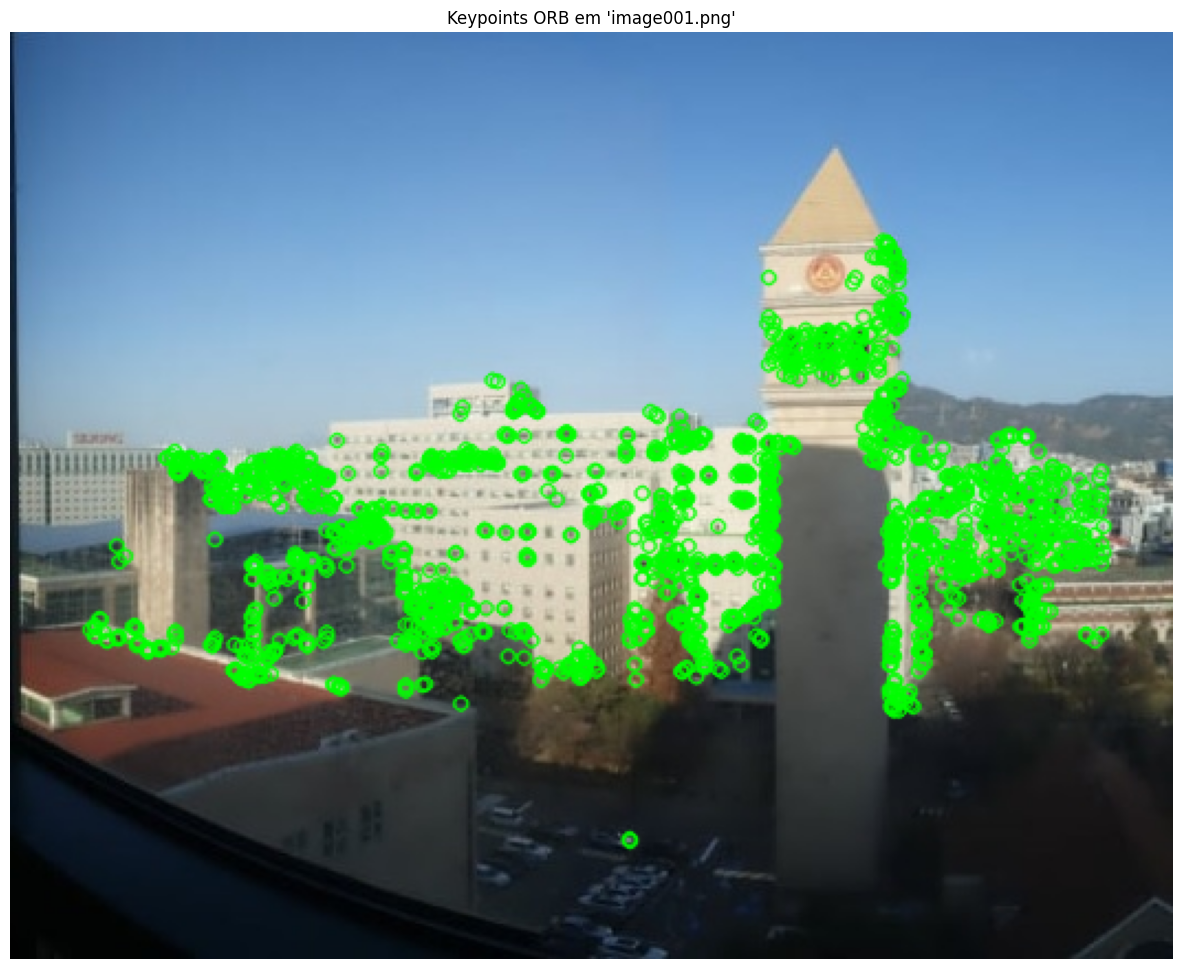

Imagem: 'image002.png' - Keypoints detectados: 1977


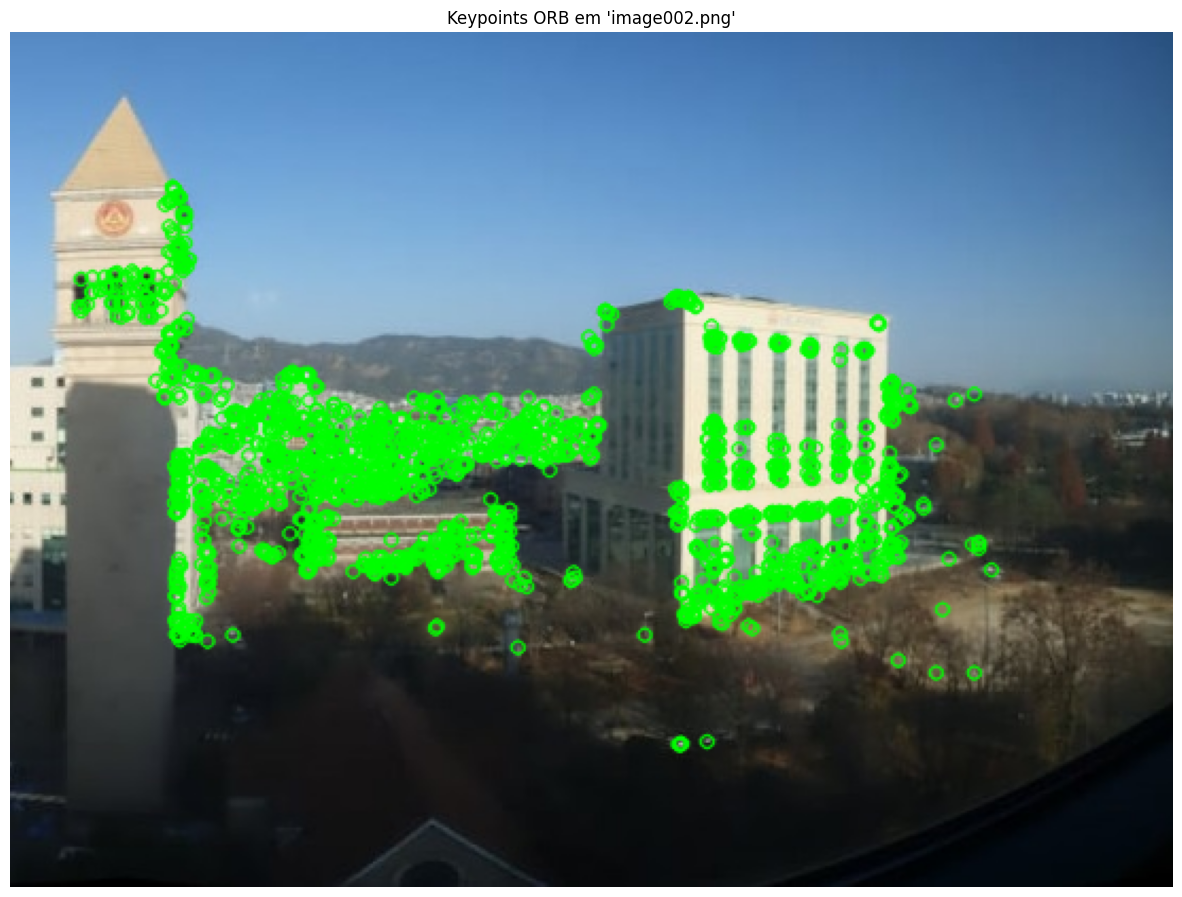

In [3]:
# 1. Inicializa o detector ORB
# nfeatures define o número máximo de keypoints a serem detectados
orb = cv2.ORB_create(nfeatures=2000)

# Itera sobre cada imagem carregada
for i, img in enumerate(images):
    # Converte a imagem para escala de cinza
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Detecta os keypoints e calcula seus descritores
    keypoints, descriptors = orb.detectAndCompute(gray_img, None)
    
    # 3. Desenha os keypoints na imagem original (colorida)
    img_with_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, # output image
        color=(0, 255, 0), # Desenha os keypoints em verde
        flags=0
    )
    
    print(f"Imagem: '{image_names[i]}' - Keypoints detectados: {len(keypoints)}")
    
    # 4. Exibe a imagem usando matplotlib
    # Converte de BGR (padrão do OpenCV) para RGB (padrão do Matplotlib)
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints ORB em '{image_names[i]}'")
    plt.axis('off') # Remove os eixos x e y
    plt.show()


Imagem: 'image001.png' - Keypoints detectados: 1214


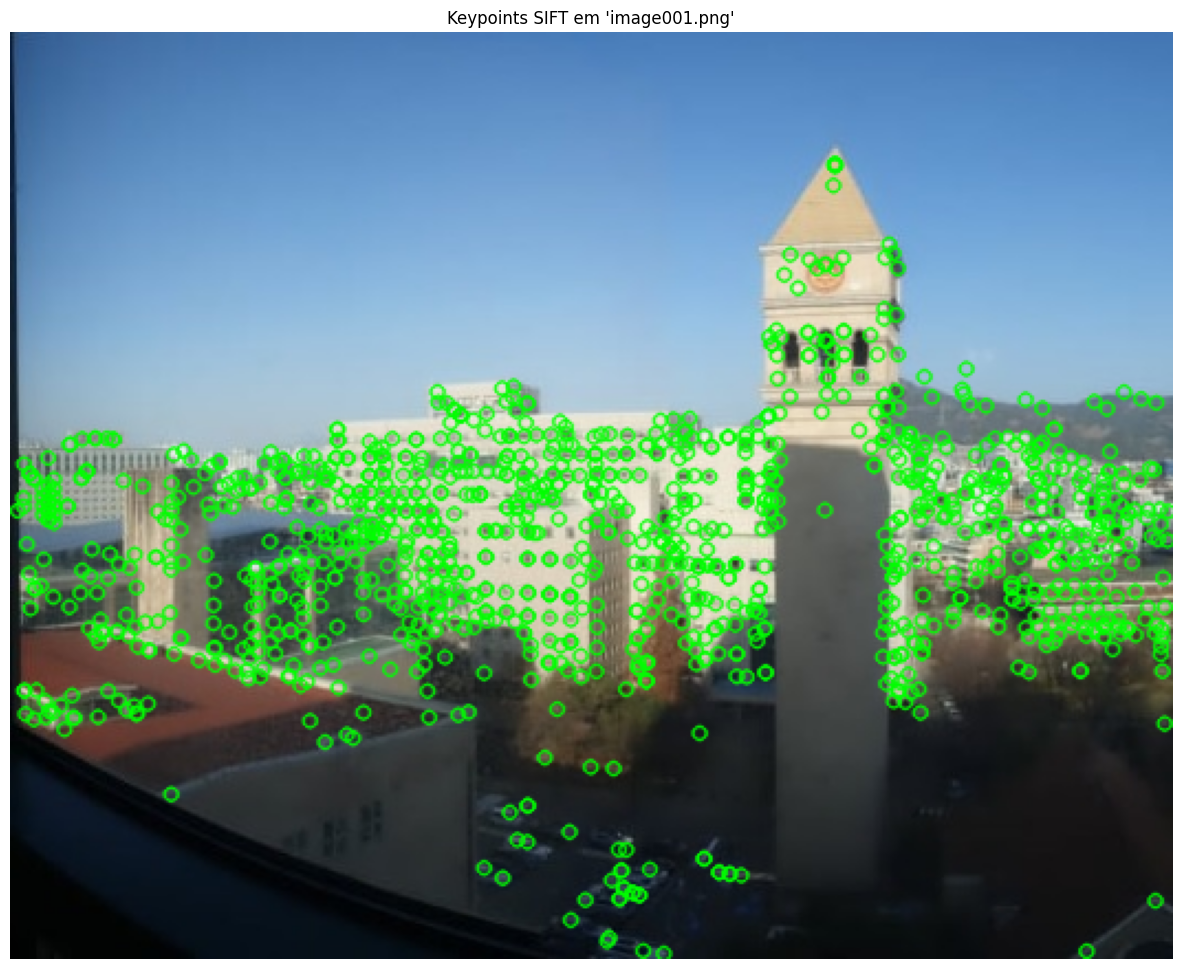

Imagem: 'image002.png' - Keypoints detectados: 1071


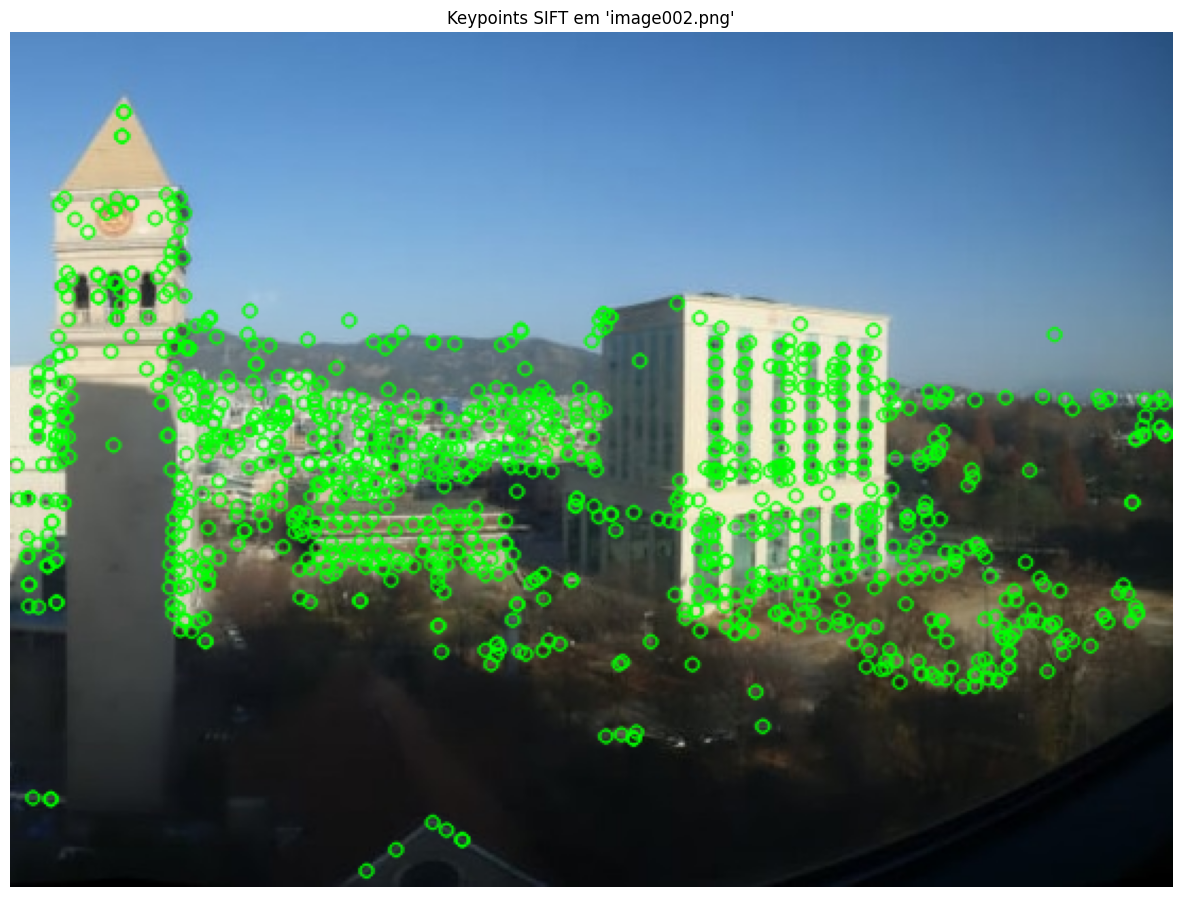

In [4]:
# 1. Inicializa o detector SIFT
# nfeatures define o número máximo de keypoints a serem detectados
sift = cv2.SIFT_create(nfeatures=2000)

# Itera sobre cada imagem carregada
for i, img in enumerate(images):
    # Converte a imagem para escala de cinza
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Detecta os keypoints e calcula seus descritores
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    
    # 3. Desenha os keypoints na imagem original (colorida)
    img_with_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, # output image
        color=(0, 255, 0), # Desenha os keypoints em verde
        flags=0
    )
    
    print(f"Imagem: '{image_names[i]}' - Keypoints detectados: {len(keypoints)}")
    
    # 4. Exibe a imagem usando matplotlib
    # Converte de BGR (padrão do OpenCV) para RGB (padrão do Matplotlib)
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints SIFT em '{image_names[i]}'")
    plt.axis('off') # Remove os eixos x e y
    plt.show()


Imagem: 'image001.png' - Keypoints detectados: 1071


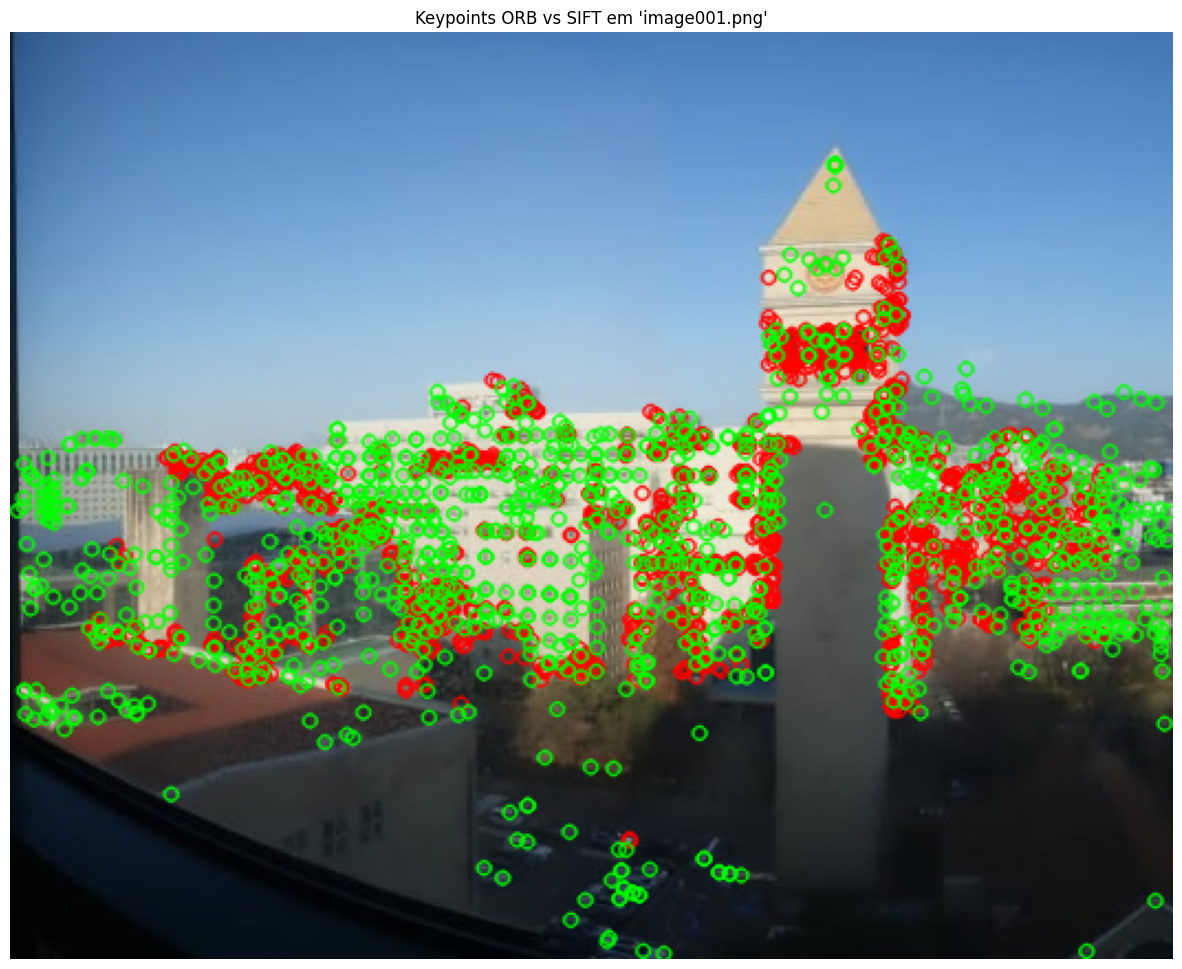

Imagem: 'image002.png' - Keypoints detectados: 1071


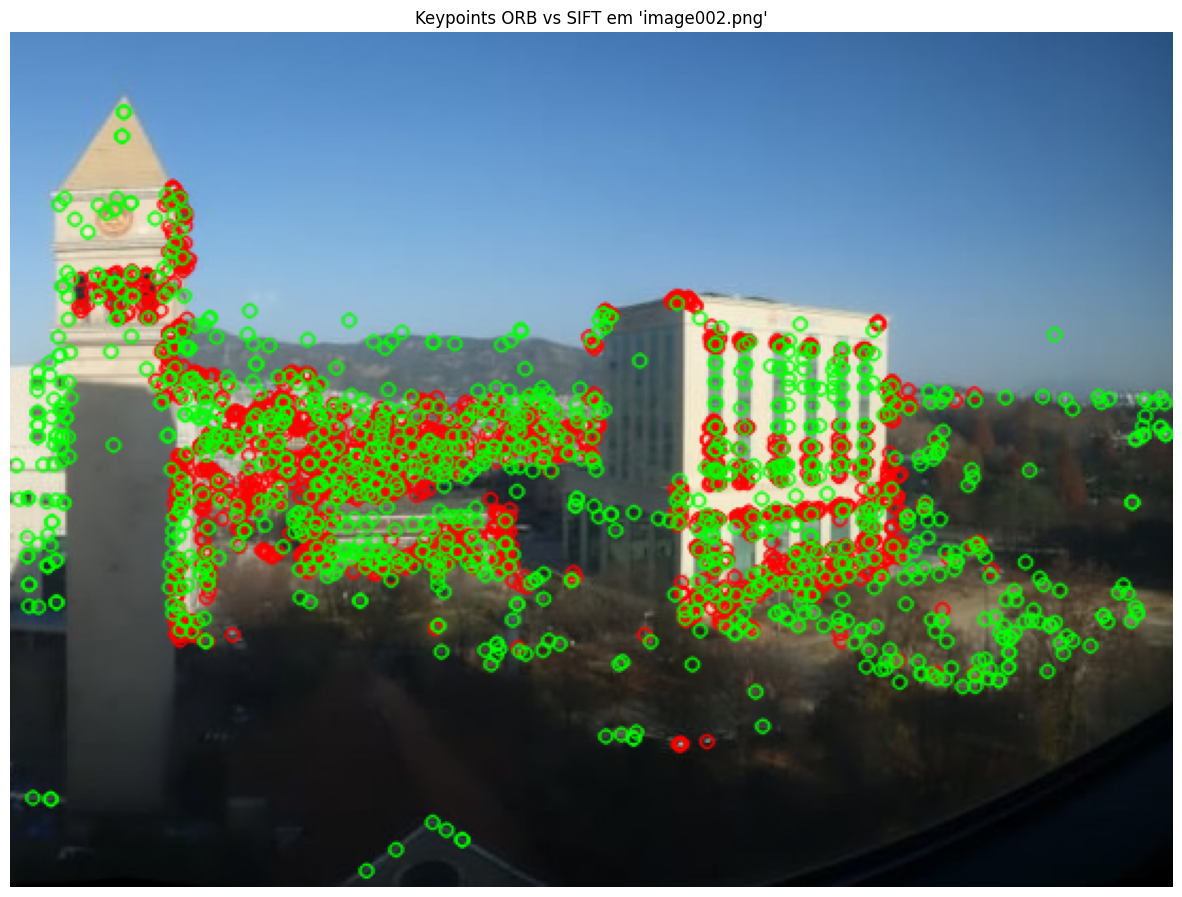

In [5]:
for i, img in enumerate(images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb_keypoints, orb_descriptors = orb.detectAndCompute(gray_img, None)
    sift_keypoints, sift_descriptors = sift.detectAndCompute(gray_img, None)

    img_with_orb_keypoints = cv2.drawKeypoints(
        img, 
        orb_keypoints, 
        None,
        color=(0, 0, 255), # keypoints ORB em vermelho
        flags=0
    )

    img_with_both_keypoints = cv2.drawKeypoints(
        img_with_orb_keypoints, 
        sift_keypoints, 
        None,
        color=(0, 255, 0), # keypoints SIFT em verde
        flags=0
    )
    
    print(f"Imagem: '{image_names[i]}' - Keypoints detectados: {len(keypoints)}")

    plt.imshow(cv2.cvtColor(img_with_both_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints ORB vs SIFT em '{image_names[i]}'")
    plt.axis('off')
    plt.show()

In [6]:
# usar SIFT por ser invariante à escala?
# TODO: escolher numero de features que facilite a visualizacao sem comprometer o resultado final
# TODO: explicar o funcionamento do ORB, do SIFT, do FLANN e da filtragem usando teste da razão de Lowe
sift = cv2.SIFT_create(nfeatures=500)

In [7]:
dataset = []
for i, img in enumerate(images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    dataset.append({'image': img, 'gray': gray_img, 'kp': keypoints, 'desc': descriptors})

In [8]:
K = 2
lowe_threshold = 0.85
flann_matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [9]:
def match_image_pair(d1, d2):
    knn_matches = flann_matcher.knnMatch(d1['desc'], d2['desc'], K)
    filtered = []
    for m, n in knn_matches:
        if m.distance < lowe_threshold * n.distance:
            filtered.append(m)
    return filtered

In [10]:
matches = match_image_pair(dataset[0], dataset[1])

In [11]:
img_matches = np.zeros((
    max(dataset[0]['image'].shape[0], dataset[1]['image'].shape[0]),
    dataset[0]['image'].shape[1] + dataset[1]['image'].shape[1],
    3
), dtype=np.uint8)

cv2.drawMatches(dataset[0]['image'], dataset[0]['kp'], dataset[1]['image'], dataset[1]['kp'], matches, img_matches)
img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

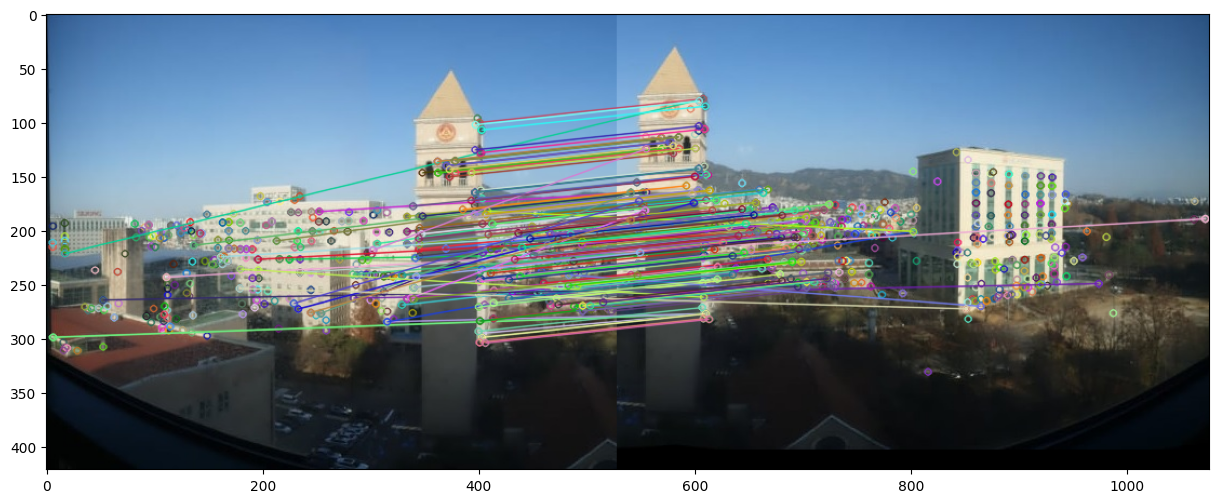

In [12]:
plt.imshow(img_matches)